# Goal of script

Created on 20/03/2023 by Claire S

This script assess the performance of the trained and fine-tuned transformer model to classify emails on a sentence-by-sentence method using the SetFit transformer model

As a recap, this method has been trained on a filtered out dataset. This filtering was based on the presence of certain words in the body of the email (specifically "bank account"/details" and "change/update/new"), which led to 0.72% of emails being selected and identified as potential bank change detail emails (This was done in the script in Step2)

This was a similar approach the product team used to specify whether an email was a bank-change-detail email.

However, this means the model was only fine-tuned on this filtered out dataset, and was specifically used to be able to distinguish between true and false positives. It has not yet been tested on completely different emails.

## Proposed assessment methods

This method will be tested in two major ways:

1. Assessment on previously manually labelled data 

- This is a dataset of 14,333 emails, which contains a few bank-change-detail emails.
- Goal: find as close to the same number of target emails as possible (assess distribution)

2. Assessment on all emails

This will involve random sampling on the full 400k dataset of emails, and can be approached in two methods:

1. Random sampling of full dataset

- Including previously labelled emails as well as including emails that would have been filtered out as potential bank change detail emails (mention "bank account"/details" and "change/update/new" in body of text)
- Goal: ?

2. Random sampling of unseen dataset

- Test the model on only the emails that were not previously seen
- Goal: Determine a) if rule-based filtering missed any bank-change-detail emails, b) if the transformer model finds many false positives 

## Proposed assessment metrics

1. Confusion matrix
2. Accuracy (v susceptible to class imbalance)
3. Precision (proportion of true positives that were correct (ratio between true positives and all positives))
4. Recall/Sensitivity/True positive rate (percentage of data samples that the model correctly identi
5. Specificity (proportion of correct true negatives)
6. F1 score (harmonic mean between precision and recall)
7. Precision-Recall (PR curve)
8. ROC (Receiver Operating Characteristics) / AUC curve
9. PR vs ROC curve

Priorities:

- the model should not miss any bank-change-detail emails (high recall, very low or zero false negatives)
- the model should be as accurate as possible (not flag too many false positives)

Understand the model's tradeoff between underfitting and overfitting (bias-variance tradeoff) as well as the precision-recall tradeoff 

### Sources:

https://towardsdatascience.com/various-ways-to-evaluate-a-machine-learning-models-performance-230449055f15

https://www.analyticsvidhya.com/blog/2020/09/precision-recall-machine-learning/


In [3]:
from setfit import SetFitModel
import sys
import ipynb
import re
import pandas as pd
sys.path.append('/project/Xelix_Project/utils')

In [4]:
from ipynb.fs.full.Regex_html_Functions import clean_websites, clean_fluff
from ipynb.fs.full.Loop_Functions import sentence_by_sentence

In [3]:
%%time
# load trained model
model = SetFitModel._from_pretrained('trained_models/SetFit_Trained6')

CPU times: user 2.68 s, sys: 1.13 s, total: 3.81 s
Wall time: 3.62 s


## Import labelled data

This part will run on the 

In [4]:
# df = pd.read_csv("data/checked_emails.csv")
df = pd.read_csv("data/Target_emails_V3.csv")
df = df.rename(columns={'bank-detail-location': 'bank_detail_loc'})
df.head()

# filter on the ones that are clear cases
this_df = df.query("final_label != -1").reset_index(drop=True)

# rename some columns
this_df = this_df.rename(columns={"email_text_body":"text","final_label":"label"})
this_df["label_text"] = this_df.apply(lambda row: "positive" if row["label"] else "negative", axis = 1)

# shuffle and how much of this to take (frac = 1, shuffles and selects all)
this_df = this_df.sample(frac=1)

print(len(this_df))
perc = (sum(this_df["label"])*100)/len(this_df)
print(f'true positives: {this_df["label"].sum()}, {"{:.1f}".format(perc)}%')
this_df.head(1)

996
true positives: 440, 44.2%


,Index,iter_count_list,email_id,is_part_of_thread,num_in_thread,thread_id,initial_domain,from_address,from_name,sent_to,...,text,label,label_james,true_positives,false_positives,uncertain,email_type,bank_detail_loc,has_signature,label_text
151,3339,1680,443315,True,1,443315_t,dorchestercollection.com,['caroline@crawfords.co.uk'],Caroline Sullivan,['APInvoicequeries.UK@dorchestercollection.com...,...,Good Afternoon I hope this email finds you te...,0,0.0,NaN,NaN,0,human,0,1.0,negative


# Sentence-by-Sentence

Loop through all sentences in the email and classify each

In [5]:
# import logging

In [6]:
# # function for this loop
# def sentence_by_sentence(df, model,save_prob=False):
#     '''Classify the text of the emails in a sentence-by-sentence manner
#     '''
    
#     email_iter = 1

#     if save_prob == True:
#         sentence_cols = ['email_iter','email_id','num_in_thread',
#                      'sentence','true_label','true_class','prob0','prob1','y_pred']
#     else:
#         sentence_cols = ['email_iter','email_id','num_in_thread',
#                          'sentence','true_label','true_class','y_pred']
    
#     df_list = []

#     # to split the sentences by
#     split_sentence_string = "[.?!]"

#     # change name of df here
#     for email in df.itertuples():
        
#         # try/except handling here
#         try:

#             clean_text = clean_websites(email.text)
#             clean_text2 = clean_fluff(clean_text)
#             sentences = re.split(split_sentence_string,clean_text2)

#             # some counters
#             email_iter += 1
#             sum_score = 0

#             len_email = len(sentences)

#             for s in sentences:

#                 # check if this bit of the list is empty
#                 if len(s.strip()) == 0:
#                     continue
#                 else:

# #                     preds = model([s])
# #                     this_label = preds.item()
# #                     sum_score += this_label
                    
#                     # display probabilities of each class
#                     if save_prob == True:
#                         proba = model.predict_proba([s])
#                         probs = proba.tolist()
                    
#                         prob0 = probs[0][0]
#                         prob1 = probs[0][1]
                    
#                         if prob0 > prob1:
#                             this_label = 0
#                         elif prob1 >= prob0:
#                             this_label = 1
                        
#                         sum_score += this_label
                        
#                         # save row data
#                         row_data = [email_iter, email.email_id, email.num_in_thread,
#                                     s, email.label, email.label_text, prob0, prob1, this_label]
                        
#                     else:

#                         preds = model([s])
#                         this_label = preds.item()
#                         sum_score += this_label
                        
#                         # save row data
#                         row_data = [email_iter, email.email_id, email.num_in_thread,
#                                     s, email.label, email.label_text, this_label]

#                     df_row = pd.DataFrame([row_data],columns = sentence_cols)
#                     df_list.append(df_row)

#             ### save email sentence info
#             sentence_df = pd.concat(df_list, ignore_index=True)

#             ### save the meta email info
#             perc_flag = "{:.1f}".format((sum_score*100)/len_email)

#             # binary coding 
#             y_pred = 1 if sum_score > 0 else 0
#             diff = 0 if y_pred == email.label else 1
            
#             # values to append to the big data frame
#             df.at[email.Index,'email_iter'] = email_iter
#             df.at[email.Index,'sum_score'] = sum_score
#             df.at[email.Index,'len_email'] = len_email
#             df.at[email.Index,'perc_flag'] = perc_flag
#             df.at[email.Index,'y_pred'] = y_pred
#             df.at[email.Index,'diff'] = diff
            
#         except:
#             print(f'error occurred at email_iter: {email_iter} email_id: {email.email_id} thread_id: {email.thread_id}')
# #             logging.exception('')

#     return sentence_df, df

In [7]:
%%time
email_df, meta_df = sentence_by_sentence(this_df, model, save_prob=True)

IntProgress(value=0, max=996)

CPU times: user 37min 42s, sys: 17 s, total: 37min 59s
Wall time: 37min 56s


In [1]:
this_meta = 'data/Step4_Data/meta_V3.csv'
this_email_df = 'data/Step4_Data/sentences_V3.csv'

In [9]:
email_df

,email_iter,email_id,num_in_thread,sentence,true_label,true_class,prob0,prob1,y_pred
0,2,453885,0,"Turkana, I hope this email finds you well",1,positive,0.997032,0.002968,0
1,2,453885,0,Please could you advise a payment run date to...,1,positive,0.997252,0.002748,0
2,2,453885,0,99,1,positive,0.984819,0.015181,0
3,2,453885,0,We urgently need to get an update on this bal...,1,positive,0.997171,0.002829,0
4,2,453885,0,Please ensure any payments are now sent to ou...,1,positive,0.003617,0.996383,1
...,...,...,...,...,...,...,...,...,...
14943,997,390247,0,Any personal views expressed within this comm...,1,positive,0.997163,0.002837,0
14944,997,390247,0,or Driver Hire Belfast WARNING: Email is not...,1,positive,0.997112,0.002888,0
14945,997,390247,0,Please bear this in mind when emailing us,1,positive,0.997066,0.002934,0
14946,997,390247,0,Although this email and its attachments are b...,1,positive,0.997253,0.002747,0


In [10]:
meta_df

,Index,iter_count_list,email_id,is_part_of_thread,num_in_thread,thread_id,initial_domain,from_address,from_name,sent_to,...,email_type,bank_detail_loc,has_signature,label_text,email_iter,sum_score,len_email,perc_flag,y_pred,diff
953,19731,12250,453885,False,0,FALSE,diversey.com,jordan.lansbury@diversey.com,jordan.lansbury@diversey.com,{Turkana.Kirollos@dorchestercollection.com},...,human,body,1.0,positive,2.0,2.0,13.0,15.4,1.0,0.0
668,28877,17762,459397,True,1,459397_t,dorchestercollection.com,['clare@totallyuk.com'],Clare Dickens,['APInvoicequeries.UK@dorchestercollection.com'],...,NaN,NaN,NaN,positive,3.0,1.0,10.0,10.0,1.0,0.0
877,55304,48635,266140,False,0,FALSE,complete.co.uk,accounts@complete.co.uk,accounts@complete.co.uk,{purchase.ledger@evo-group.co.uk},...,automatic-reply,body,1.0,positive,4.0,1.0,6.0,16.7,1.0,0.0
386,56950,35844,427479,True,2,427479_t,atlasfm.com,Julie.Rivers@atlasfm.com,Julie.Rivers@atlasfm.com,{APInvoicequeries.UK@dorchestercollection.com},...,human,0,1.0,negative,5.0,0.0,4.0,0.0,0.0,0.0
756,47307,30937,422572,False,0,FALSE,enotriacoe.com,creditcontrol@enotriacoe.com,creditcontrol@enotriacoe.com,"{APInvoicequeries.UK@dorchestercollection.com,...",...,NaN,NaN,NaN,positive,6.0,1.0,18.0,5.6,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,58062,36506,428141,True,1,428141_t,dorchestercollection.com,['CreditControl@allanreederltd.co.uk'],Credit Control,['Tetchie.Bustos@dorchestercollection.com'],...,human,signature,1.0,positive,993.0,1.0,10.0,10.0,1.0,0.0
405,87049,31011,372787,True,1,372787_t,backupworks.com,[' mailto:APCustomerService@scripps.com '],Appids_Corp_AP Customer Service [ mailto:APCus...,[],...,NaN,NaN,NaN,negative,994.0,0.0,24.0,0.0,0.0,0.0
297,5735,5122,222630,False,0,FALSE,encorepersonnel.co.uk,invoicing@encorepersonnel.co.uk,invoicing@encorepersonnel.co.uk,{purchase.ledger@evo-group.co.uk},...,NaN,NaN,NaN,negative,995.0,0.0,7.0,0.0,0.0,0.0
117,55086,49903,217410,False,0,FALSE,artsystems.co.uk,accounts@artsystems.co.uk,accounts@artsystems.co.uk,{purchase.ledger@evo-group.co.uk},...,automatic-reply,0,1.0,negative,996.0,0.0,21.0,0.0,0.0,0.0


In [11]:
email_df.head(30)

,email_iter,email_id,num_in_thread,sentence,true_label,true_class,prob0,prob1,y_pred
0,2,453885,0,"Turkana, I hope this email finds you well",1,positive,0.997032,0.002968,0
1,2,453885,0,Please could you advise a payment run date to...,1,positive,0.997252,0.002748,0
2,2,453885,0,99,1,positive,0.984819,0.015181,0
3,2,453885,0,We urgently need to get an update on this bal...,1,positive,0.997171,0.002829,0
4,2,453885,0,Please ensure any payments are now sent to ou...,1,positive,0.003617,0.996383,1
5,2,453885,0,The correct bank details are: Name: Zenith Hy...,1,positive,0.995551,0.004449,0
6,2,453885,0,lansbury @ diversey,1,positive,0.996893,0.003107,0
7,2,453885,0,com W: | W: Zenith Hygiene Group Registered ...,1,positive,0.997155,0.002845,0
8,2,453885,0,Company Number: 06707511 Zenith is now part o...,1,positive,0.003405,0.996595,1
9,2,453885,0,PLEASE PAY INTO THIS ACCOUNT : GBP Name: Zeni...,1,positive,0.997152,0.002848,0


In [12]:
# grouped = email_df.groupby(['email_id', 'true_label']).agg({'prob1': 'max', 'y_pred': 'sum'}).reset_index()
# grouped = grouped.rename(columns={"y_pred": "sum_score"})
# # grouped['y_pred'] = grouped['sum_score'].apply(lambda x: 1 if x > 0 else 0)
# grouped['y_pred'] = grouped['prob1'].apply(lambda x: 1 if x > 0.2 else 0)
# grouped['diff'] = grouped.apply(lambda row: 1 if row['true_label'] != row['y_pred'] else 0, axis=1)
# grouped

In [13]:
meta_df.to_csv(this_meta)
email_df.to_csv(this_email_df)

In [5]:
meta_df = pd.read_csv(this_meta)

FileNotFoundError: [Errno 2] No such file or directory: 'data/Step4_Data/meta_V3.csv'

To run 996 emails, it takes approx 38 mins??

calculating the probabilities takes a lot longer apparently - I have tried to speed this up a little bit

# Assess output

# Plot how many emails are positive and how many are negative

In [14]:
# print(sum(email_df.query("y_pred == 1")))
# print(sum(meta_df['label_text']=='positive'))

In [ ]:
# pandas options
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 300)

In [ ]:
# email_df.head(10)

## Inspect positive examples

In [ ]:
positives_sentences = email_df.query("y_pred == 1 & true_label == 1").reset_index(drop=True)
print(len(positives_sentences))
positives_sentences

# Inspect the false negatives

In [ ]:
false_negs_ids = meta_df.loc[(meta_df['diff'] == 1) & (meta_df['y_pred'] == 0), 'email_iter']
# false_negs_ids = meta_df.loc[(meta_df['diff'] == 1), 'email_iter']

# filter the merged dataframe to keep only the rows where 'different' column is 1
exps = email_df[email_df['email_iter'].isin(false_negs_ids)].reset_index(drop=True)

# print the resulting dataframe
print(len(false_negs_ids))
print(len(exps))
exps[0:1000]

In [ ]:
meta_df.loc[meta_df['email_id'] == 355606, 'label'] = 1
meta_df.loc[meta_df['email_id'] == 355606, 'diff'] = 0

Emails to recode: 

as negatives

- 434360
- 383364
- 383539

as positives

- 355578
- 191718
- 355978
- 355979
- 191731
- 451714
- 191713
- 443109
- 355977
- 180262
- 452276
- 355606

# Inspect the false positives

In [ ]:
false_pos_ids = meta_df.loc[(meta_df['diff'] == 1) & (meta_df['y_pred'] == 1), 'email_iter']
# false_negs_ids = meta_df.loc[(meta_df['diff'] == 1), 'email_iter']

# filter the merged dataframe to keep only the rows where 'different' column is 1
exps = email_df[email_df['email_iter'].isin(false_pos_ids)].reset_index(drop=True)

# print the resulting dataframe
print(len(false_pos_ids))
print(len(exps))
exps[0:1000]

## Inspect some negative examples

In [ ]:
neg_exp = email_df.head(200).query("y_pred == 0").reset_index(drop=True)
print(len(neg_exp))
neg_exp

## Some stats reporting

In [ ]:
meta_df.columns

In [ ]:
all_pos = meta_df.loc[(meta_df['label'] == 1)].shape[0]
all_neg = meta_df.loc[(meta_df['label'] == 0)].shape[0]
true_positives = meta_df.loc[(meta_df['label'] == 1) & (meta_df['y_pred'] == 1)].shape[0]
false_positives = meta_df.loc[(meta_df['label'] == 0) & (meta_df['y_pred'] == 1)].shape[0]
true_negatives = meta_df.loc[(meta_df['label'] == 0) & (meta_df['y_pred'] == 0)].shape[0]
false_negatives = meta_df.loc[(meta_df['label'] == 1) & (meta_df['y_pred'] == 0)].shape[0]

In [ ]:
print(f'true pos: {true_positives}, false pos: {false_positives}, true negs: {true_negatives}, false negs: {false_negatives}')

In [ ]:
# Precision
precision = true_positives / (true_positives + false_positives)
# Precision
recall = true_positives / (true_positives + false_negatives)
# F1 score
f1 = 2 * ((recall * precision)/(recall + precision))

print(f'the model achieved a precision of {"{:.2f}".format(precision)}, recall of {"{:.2f}".format(recall)} and an F1 score of {"{:.2f}".format(f1)}')

# Visualisation

In [82]:
from sklearn.metrics import auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [83]:
plt.style.use('default')


## For labelled data

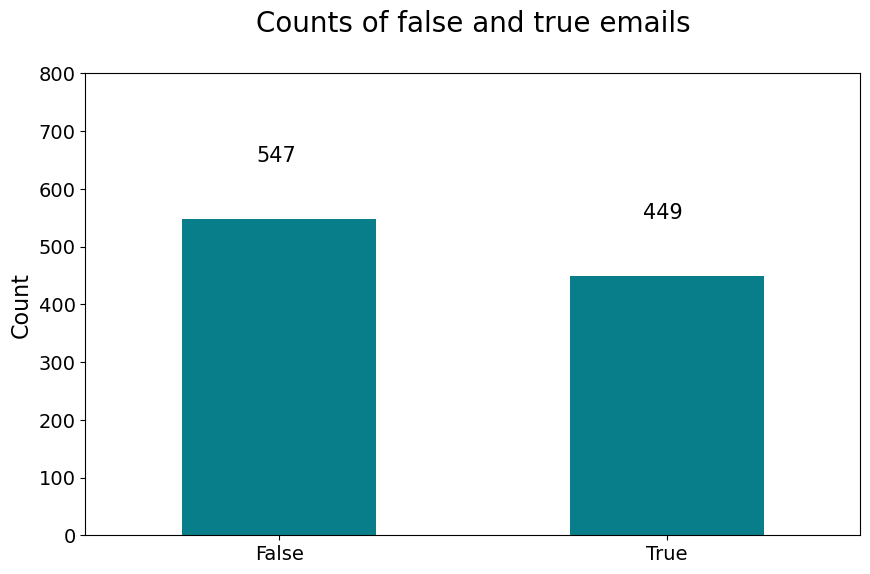

In [84]:
# barplots of the total values
ax = meta_df['label'].value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='#087E8B')
ax.set_title('Counts of false and true emails', size=20, pad=30)
ax.set_ylabel('Count', fontsize=16)
plt.ylim((0,800))
ax.set_xticklabels(["False", "True"],rotation = 0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.style.use('seaborn-deep')

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 100, str(round(i.get_height(), 2)), fontsize=15)

### confusion matrix

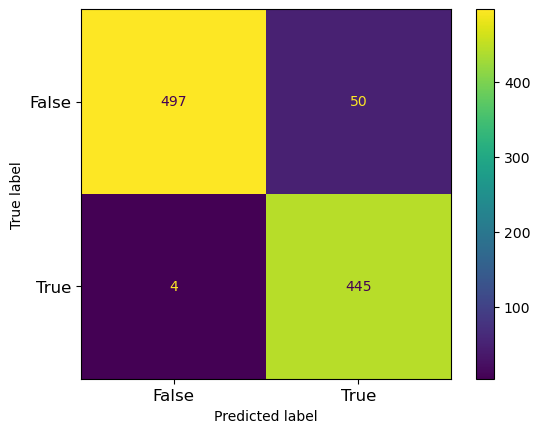

In [85]:
# y_actual = meta_df['final_label']
# y_pred = meta_df['y_pred']

y_actual = meta_df['label']
y_pred = meta_df['y_pred']

confusion_matrix = confusion_matrix(y_actual,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Precision-recall curve

In [88]:
meta_df.columns

Index(['Unnamed: 0', 'Index', 'iter_count_list', 'email_id',
       'is_part_of_thread', 'num_in_thread', 'thread_id', 'initial_domain',
       'from_address', 'from_name', 'sent_to', 'sent_to_how_many', 'bcc', 'cc',
       'reply_to_address', 'internal_date', 'category_id', 'category_slug',
       'has_sort_code', 'sort_code', 'has_attachment', 'mentions_bank',
       'mentions_change', 'mentions_account_specifics', 'mentions_statement',
       'mentions_invoice', 'mentions_fraud', 'has_attention_ext_flag',
       'has_alert_attach_flag', 'subject', 'attachments', 'text', 'label',
       'label_james', 'true_positives', 'false_positives', 'uncertain',
       'email_type', 'bank_detail_loc', 'has_signature', 'label_text',
       'email_iter', 'sum_score', 'len_email', 'perc_flag', 'y_pred', 'diff'],
      dtype='object')

In [90]:
grouped = email_df.groupby(['email_id']).agg({'prob1': 'max'}).reset_index()
# grouped['y_pred_p'] = grouped['prob1'].apply(lambda x: 1 if x > 0.2 else 0)
grouped.head(10)

,email_id,prob1
0,167522,0.005316
1,168030,0.019641
2,168509,0.515896
3,168703,0.996615
4,168709,0.002951
5,169379,0.019641
6,169816,0.019641
7,170704,0.019641
8,170938,0.002951
9,171118,0.019641


In [91]:
meta_df = pd.merge(meta_df, grouped, on = 'email_id')
meta_df.head(10)

,Unnamed: 0,Index,iter_count_list,email_id,is_part_of_thread,num_in_thread,thread_id,initial_domain,from_address,from_name,sent_to,sent_to_how_many,bcc,cc,reply_to_address,internal_date,category_id,category_slug,has_sort_code,sort_code,has_attachment,mentions_bank,mentions_change,mentions_account_specifics,mentions_statement,mentions_invoice,mentions_fraud,has_attention_ext_flag,has_alert_attach_flag,subject,attachments,text,label,label_james,true_positives,false_positives,uncertain,email_type,bank_detail_loc,has_signature,label_text,email_iter,sum_score,len_email,perc_flag,y_pred,diff,prob1
0,953,19731,12250,453885,False,0,FALSE,diversey.com,jordan.lansbury@diversey.com,jordan.lansbury@diversey.com,{Turkana.Kirollos@dorchestercollection.com},1,{},{Accounts.CPA@dorchestercollection.com},{},2021-01-15 15:04:35+00,0,NaN,True,"""18-50-08""",True,True,True,True,False,False,False,False,False,12265 COWORTH PARK,"12265 - COWORTH PARK 150121.xls,12265001 COWORTH PARK INVOICES 150121.pdf","Good afternoon Turkana, I hope this email finds you well? Please could you advise a payment run date to clear the overdue balance of PS2523.99? We urgently need to get an update on this balance as for some reason, this goes back to August 2020 meaning the account is being reviewed by my manageme...",1,NaN,1.0,0.0,0,human,body,1.0,positive,2.0,2.0,13.0,15.4,1.0,0.0,0.996595
1,668,28877,17762,459397,True,1,459397_t,dorchestercollection.com,['clare@totallyuk.com'],Clare Dickens,['APInvoicequeries.UK@dorchestercollection.com'],1,NaN,NaN,{},14/04/2022 14:27,0,NaN,True,"""60-92-70""",True,True,True,True,False,True,False,False,False,Totally UK Invoice SI-50893,Totally-UK-Invoice-SI-50893.pdf,"Good afternoon, Thank you for your recent order, the invoice is attached for your records. Please note our new bank account details: BANCO SABADELL LONDON TOTALLY UK LTD Sort Code: 60-92-70 Account: 06211001 IBAN/BIC: GB71 BSAB 6092 7006 2110 01 Best wishes, Clare Clare Dickens Managing Direct...",1,1.0,NaN,NaN,0,NaN,NaN,NaN,positive,3.0,1.0,10.0,10.0,1.0,0.0,0.995960
2,877,55304,48635,266140,False,0,FALSE,complete.co.uk,accounts@complete.co.uk,accounts@complete.co.uk,{purchase.ledger@evo-group.co.uk},1,{},{},{accounts@complete.co.uk},2022-04-03 04:15:15+00,0,NaN,True,"""40-61-35""",True,True,True,True,True,False,False,True,False,Complete Business Solutions Monthly Statement,A_Statement__Current.pdf,"Attention: This email originated outside of our organisation. Please be extra vigilant when opening attachments or clicking links. Hello Please find attached a copy of your up to date statement of account from Complete Business Solutions Group. If you have any queries, please quote your Accoun...",1,NaN,1.0,0.0,0,automatic-reply,body,1.0,positive,4.0,1.0,6.0,16.7,1.0,0.0,0.996593
3,386,56950,35844,427479,True,2,427479_t,atlasfm.com,Julie.Rivers@atlasfm.com,Julie.Rivers@atlasfm.com,{APInvoicequeries.UK@dorchestercollection.com},1,NaN,NaN,{},2022-07-06 11:07:17+00,0,NaN,False,NaN,False,True,True,False,False,False,False,False,False,RE: Dorchester / 45 Park Lane -- statement request ref4177,NaN,"Good Morning, Statements as requested. Kind regards Julie Rivers Accounts Receivable Admin. Please Note: Should you receive any emails from me regarding a change in bank details, please call the office to check the validity of the request prior to making any change to your systems 0208 755 67...",0,NaN,0.0,1.0,0,human,0,1.0,negative,5.0,0.0,4.0,0.0,0.0,0.0,0.003178
4,756,47307,30937,422572,False,0,FALSE,enotriacoe.com,creditcontrol@enotriacoe.com,creditcontrol@enotriacoe.com,"{APInvoicequeries.UK@dorchestercollection.com,Invoicepayments.UK@dorchestercollection.com}",2,{},{},{},2022-10-04 11:54:47+00,0,NaN,False,NaN,True,True,True,False,True,False,False,False,False,Enotria&Coe Statement D00237 - Dorchester Hotel Limited,"ATT00001.bin,Open documents.zip,Statement.pdf","Dear Sir/Madam , Please find attached your up-to-date statement showing all your recent transactions . Please ensure you

In [92]:
y_actual = meta_df['label']
y_probs = meta_df['prob1']

# baseline is ratio of positives and negatives
baseline_model = sum(y_actual) / len(y_actual)

precision, recall, _ = precision_recall_curve(y_actual, y_probs)
auc = auc(recall, precision)

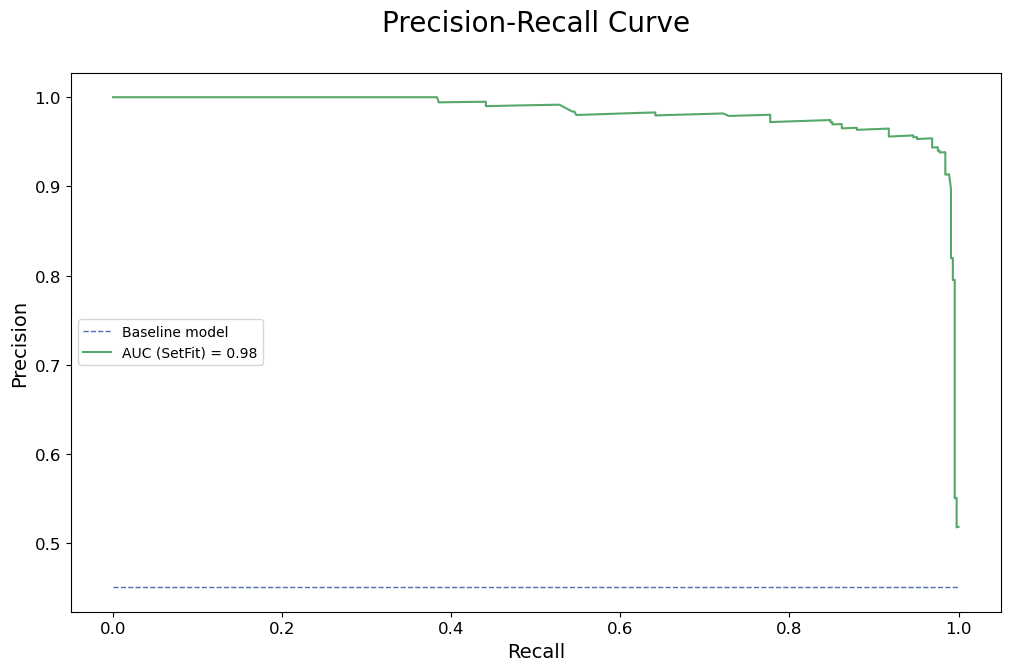

In [93]:
# plot it
plt.figure(figsize=(12, 7))
plt.plot([0, 1], [baseline_model, baseline_model], linestyle='--', linewidth = 1, label='Baseline model')
plt.plot(recall, precision, label=f'AUC (SetFit) = {auc:.2f}')
plt.title('Precision-Recall Curve', size=20, pad=30)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.style.use('seaborn-deep')
plt.legend();

In [167]:
plt.style.library['seaborn-deep']

RcParams({'axes.prop_cycle': cycler('color', ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']),
          'patch.facecolor': '#4C72B0'})

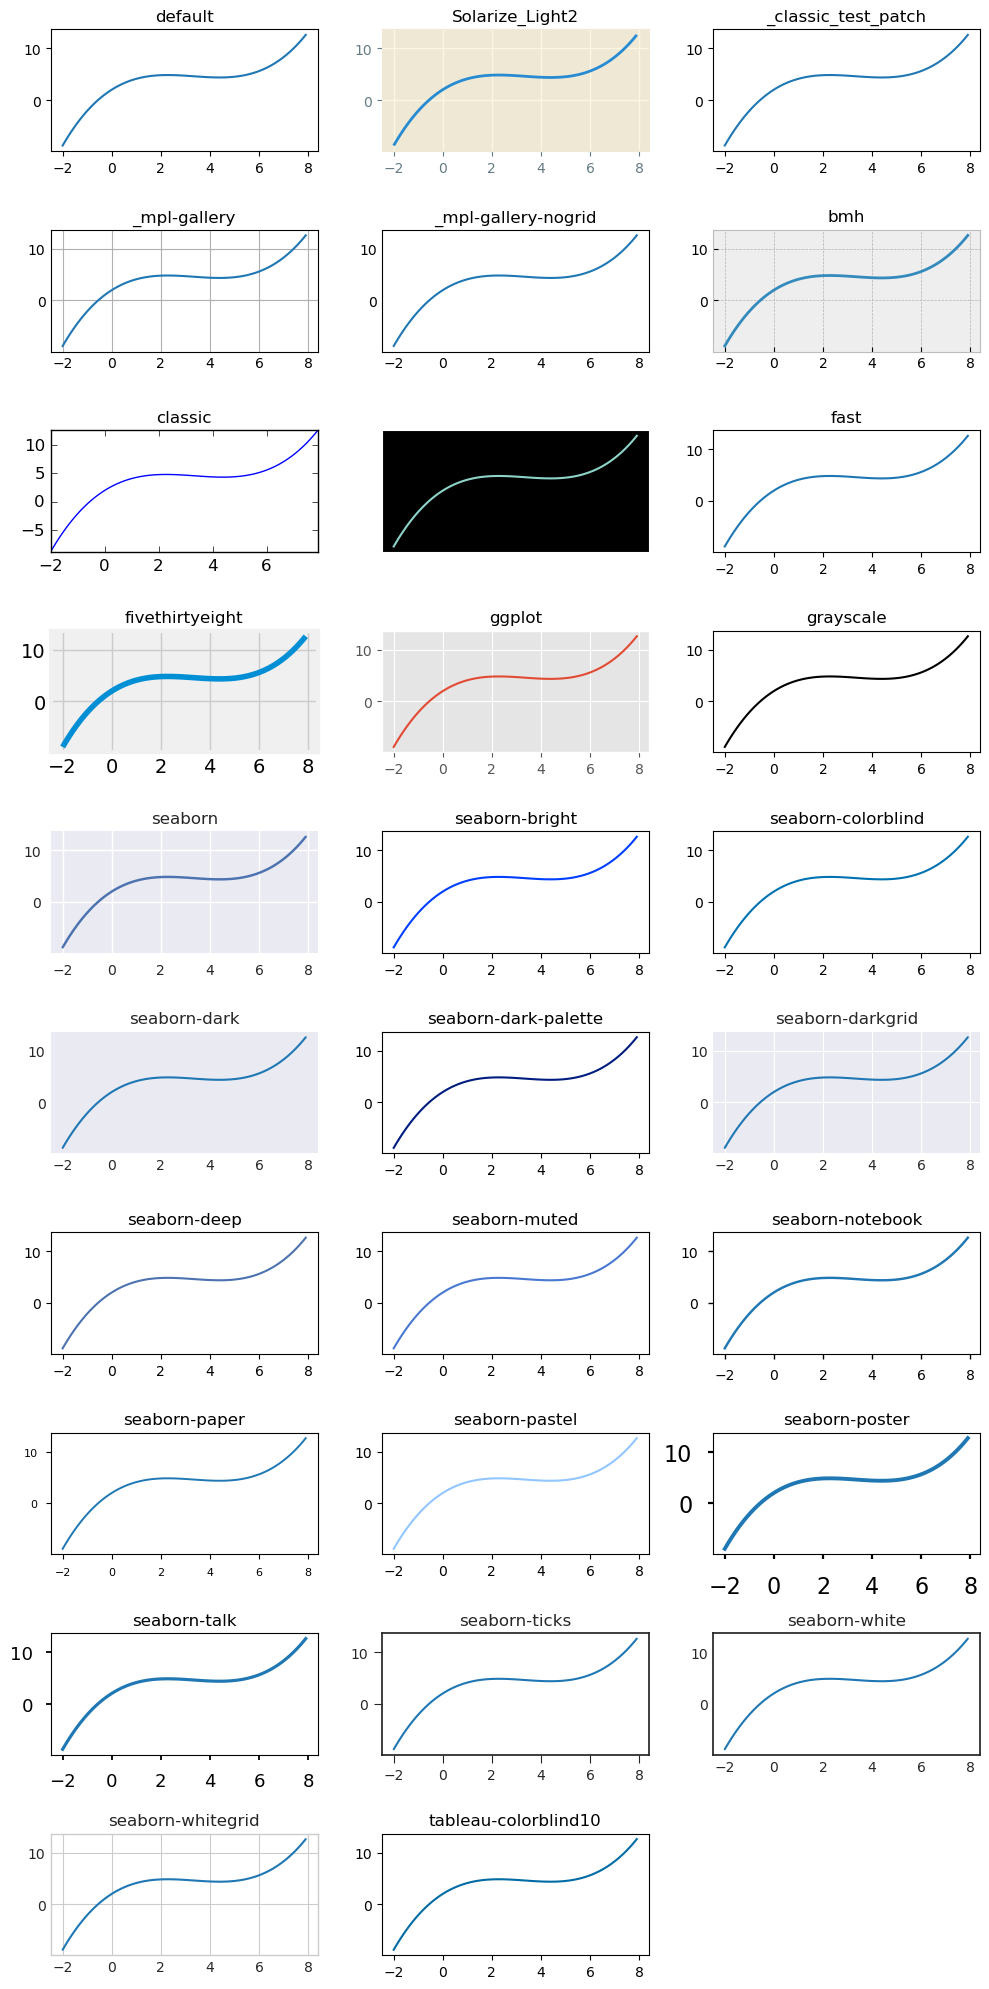

In [166]:
x = np.arange(-2, 8, .1)
y = .1 * x ** 3 - x ** 2 + 3 * x + 2
fig = plt.figure(dpi=100, figsize=(10, 20), tight_layout=True)
available = ['default'] + plt.style.available
for i, style in enumerate(available):
    with plt.style.context(style):
        ax = fig.add_subplot(10, 3, i + 1)
        ax.plot(x, y)
    ax.set_title(style)

In [2]:
from ipywidgets import IntProgress
from IPython.display import display
import time

In [ ]:
max_count = 10
f = IntProgress(min = 0, max = max_count)
display(f)

count = 0
while count <= max_count:
    f.value += 1
    

# Manual Labelling vs SetFit differences

### How many are different?

Here I am filtering on the emails that had recieved a different label from the manual labelling (e.g. the entire email was labelled as a 0 or a 1) and whether the fine-tuned SetFit model had flagged any sentences. 

Differences could arise because:

- the email was labelled a 0, but SetFit has flagged at least 1 sentence as a change of bank details email
- the email was labelled as a 1, but SetFit has flagged 0 sentences

In [ ]:
# 9% of the 
perc = (sum(meta_df["diff"])*100)/len(meta_df)
print(f'Number of diff emails: {sum(meta_df["diff"])}/{len(meta_df)} ({"{:.1f}".format(perc)}%)')

In [ ]:
# pandas options
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)

In [ ]:
# filter out the different labelled emails
diff_ids = meta_df.loc[meta_df['diff'] == 1, 'email_iter']

# filter the merged dataframe to keep only the rows where 'different' column is 1
exps = email_df[email_df['email_iter'].isin(diff_ids)].reset_index(drop=True)

# print the resulting dataframe
exps[0:300]

In [ ]:
exps.to_csv('different_email_labels.csv')

In [ ]:
exps = pd.read_csv('different_email_labels.csv')
exps

In [207]:
def clean_websites(text):
    '''Clean text in following ways:
    - remove all https or www links <>
    - remove emails
    - remove phone numbers
    '''
    
#     url_pattern = r'(https?:\/\/\S+?\.(com|co\.uk|org|co|uk))|(www\.\S+?\.(com|co\.uk|org|co|uk))'
    url_pattern = r'(?:https?://|www\.)\S*' #r'(?:https?://|www\.)\S+?'
    email_pattern = r'\b\w+@\w+\.\w+\b'
    tel_pattern = r'(?:Tel|T):[\s\d\-\+\(\)]*'
    phone_pattern = r'(?:\+|00)?(?:\d{1,3}[\s-]?)?(?:\(\d{1,5}\)|\d{1,5})[\s-]?\d{3,4}[\s-]?\d{3,4}'
#     phone_pattern = r'(?:(?:\+|00)\d{1,3}[\s-]?\d{1,4}[\s-]?)?\(?0?\d{1,5}\)?[\s-]?\d{3,4}[\s-]?\d{3,4}'  # Matches phone numbers in various formats
    
    text = re.sub(url_pattern, '', text) # clean websites and replace 
    text = re.sub(email_pattern, '', text)
    text = re.sub(email_pattern, '', text)
    text = re.sub(tel_pattern, '', text)
    
    return text

In [208]:
text = clean_websites("Attention: This email originated outside of our organisation. Please be extra vigilant when opening attachments or clicking links.   Dear VOW Europe,  Please find attached the statement for your account with EET showing all transactions for the period 16/08/22.  Online at http://webdefence.global.blackspider.com/urlwrap/?q=AXicE3RnWDyZgUFvCgNDUU6lsUGiXnFRmV5uYmZOcn5eSVF-jl5yfi6Dkbm7RYR7lLGhgbGZqQlDQWlRckZicapeTmpKemqRQ2pZvm56UX5pAVCxXmk2Q0ZJSYGVvn55ebleamoJVJCB4UsLAwMA1B0kGA&Z it is not only possible to access realtime prices and stock, but also manage the financials of your account - extract statements, track shipments and review RMAs and creditnotes.  Please note that our preferred method of payment is by bank transfer, quoting your company name and invoice number.  If you have any questions please do not hesitate to contact us on finance@eet.co.uk.  Best Regards  EET UK  http://webdefence.global.blackspider.com/urlwrap/?q=AXicE3RnWDyZgUFvCgNDUU6lsUGiXnFRmV5uYmZOcn5eSVF-jl5yfi6Dkbm7RYR7lLGhgbGZqQlDQWlRckZicapeTmpKemqRQ2pZvm56UX5pAVCxXmk2Q0ZJSYGVvn55ebleamoJVJCB4UsLAwMA1B0kGA&Z Tel: +44 (0) 333 241 9 251  Please note we have changed our Bank details:  Citibank N.A. London Branch. Account No.: 14416279 Sort Code: 18-50-08 IBAN: GB85CITI18500814416279 SWIFT: CITIGB2L EUR:IE40CITI99005100100625, SWIFT:CITIIE2X  ")

In [209]:
text

'Attention: This email originated outside of our organisation. Please be extra vigilant when opening attachments or clicking links.   Dear VOW Europe,  Please find attached the statement for your account with EET showing all transactions for the period 16/08/22.  Online at  it is not only possible to access realtime prices and stock, but also manage the financials of your account - extract statements, track shipments and review RMAs and creditnotes.  Please note that our preferred method of payment is by bank transfer, quoting your company name and invoice number.  If you have any questions please do not hesitate to contact us on .uk.  Best Regards  EET UK   Please note we have changed our Bank details:  Citibank N.A. London Branch. Account No.: 14416279 Sort Code: 18-50-08 IBAN: GB85CITI18500814416279 SWIFCITIGB2L EUR:IE40CITI99005100100625, SWIFCITIIE2X  '